In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import stats
import matplotlib.pyplot as plt
from tesser import util 
from tesser import network
from tesser import rsa
plt.rcParams['figure.figsize'] = [10, 10]
import sys
from glob import glob
        
np.set_printoptions(threshold=sys.maxsize)

/opt/anaconda3/envs/tesser_successor/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
###########
#DIRECTORY#
###########
#need to change path depending on whether you're using laptop or desktop:
#desktop:
#data_dir = '/Users/athula/Dropbox/Experiments/tesser_successor/Data/scrambled_betas'
#event_dir = '/Users/athula/Dropbox/Experiments/tesser_successor/TesserScan/rsa_scram_info'

#laptop:
data_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/Data/scrambled_betas'
event_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/TesserScan/rsa_scram_info'
avg_data_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/Data/scrambled_betas/averaged'

In [3]:
################
#SUBJECT + ROIs#
################

#load subject data:
subjs = util.subj_list()
subjs_np = np.array(subjs)

#load txt files by subj + ROI:
rois = ['b_hip_ant', 'b_hip_body', 'b_hip_tail', 'b_hip', 'l_hip_ant', 'l_hip_body', 'l_hip_tail', 'l_hip', 'r_hip_ant', 'r_hip_body', 'r_hip_tail', 'r_hip']
rois_np = np.repeat(rois,2)

#conditions
conditions = ('within', 'across')
conditions_np = np.array(conditions*len(rois))
conditions_array = [rois_np, conditions_np]

### Getting example participant data

In [4]:
#example data
ex_sub = 103
ex_roi = 'b_hip_ant'
ex_data = rsa.load_rsa(data_dir, ex_sub, ex_roi)
ex_data.shape

(126, 126)

In [5]:
ex_data

array([[ 1.0000000e+00,  8.7497950e-02, -1.5981801e-01,  4.8210803e-01,
        -8.2819400e-02,  8.2558130e-02,  1.0545306e-01,  1.6321381e-01,
         1.3349610e-01,  1.0159550e-01,  3.1206047e-01,  2.6759367e-01,
         3.4110500e-02,  6.0152610e-02, -1.3037947e-01,  6.6172750e-02,
         9.5266700e-02,  2.5435189e-01, -7.8069680e-02,  4.3957596e-01,
        -4.1105359e-01, -1.3720757e-01,  2.3413109e-01,  3.0422508e-01,
         2.2428198e-01,  1.6867071e-01, -2.6003151e-01,  6.7968260e-02,
        -1.9141942e-01, -1.7981400e-02,  2.2105336e-01, -3.3245093e-01,
         1.5915760e-02, -2.0587685e-01, -3.3798640e-02, -1.1030245e-01,
         1.9986057e-01,  2.0117253e-01, -4.7943200e-02,  1.1181973e-01,
         9.5729030e-02,  1.9670944e-01,  2.5329804e-01,  3.3718980e-02,
        -1.1973650e-01, -4.8801130e-02, -1.7750628e-01, -1.6981022e-01,
        -3.2009509e-01, -1.4616769e-01,  3.9783140e-02, -1.1169717e-01,
        -2.9340061e-01, -2.3365459e-01, -1.4550529e-01,  3.39333

In [6]:
this_event_info = rsa.load_scram_info(event_dir)
this_event_info

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/rsa.py:136: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  event_info = pd.read_csv(event_file, sep='\,', skipinitialspace=True, header=None)


,run,item,comm,bound
0,1,1,1,0
1,1,2,1,0
2,1,3,1,1
3,1,4,2,1
4,1,5,2,0
...,...,...,...,...
121,6,17,3,1
122,6,18,1,1
123,6,19,1,0
124,6,20,1,0


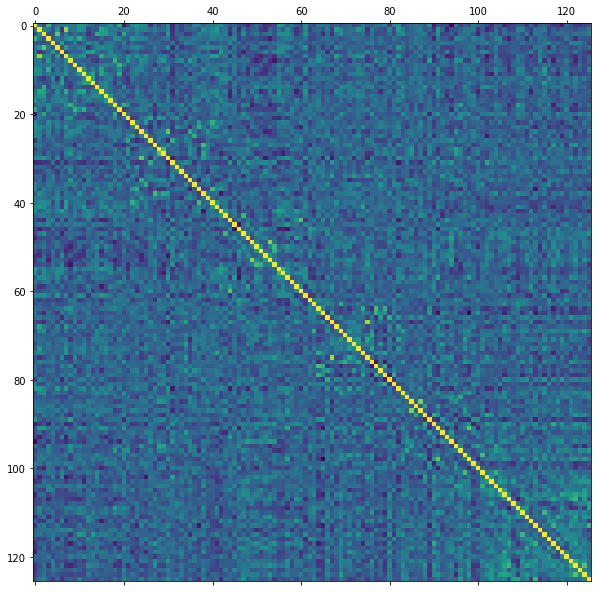

In [7]:
plt.matshow(ex_data)

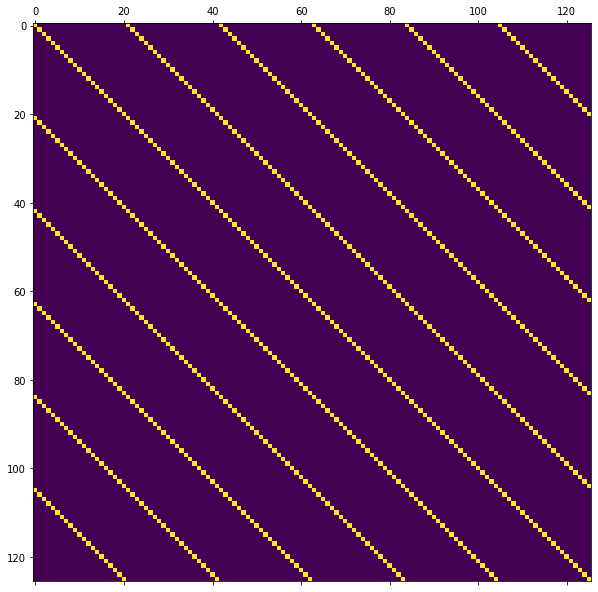

In [8]:
#same object = true 
#different object = false
items_array = np.array(this_event_info.item)
same_object = rsa.pair_eq(items_array)

plt.matshow(same_object)

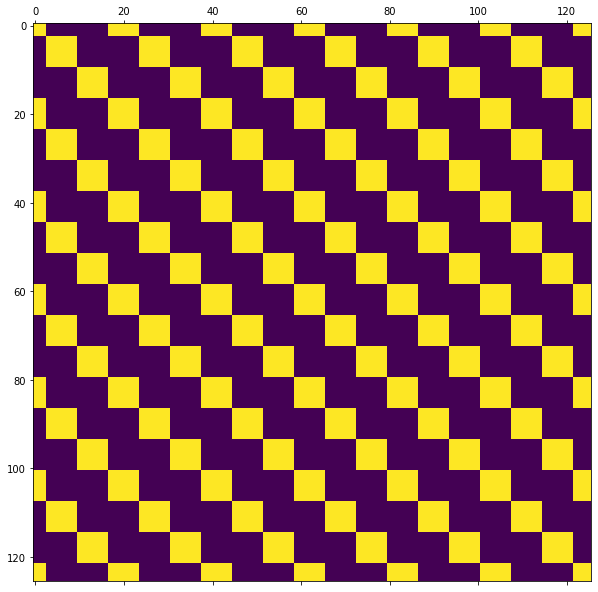

In [9]:
#within community = true 
#across community = false
comm_arry = np.array(this_event_info.comm)
within_comm = rsa.pair_eq(comm_arry)

plt.matshow(within_comm)

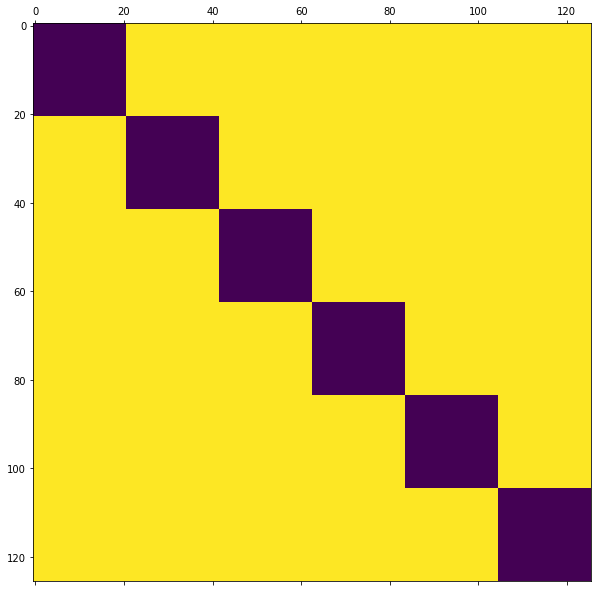

In [10]:
#appending item communities across all runs 
run_array = np.array(this_event_info.run)
across_run = rsa.pair_neq(run_array)

plt.matshow(across_run)

# Getting overall within-community and across-community means 

In [11]:
within_across_roi_overall_subj = np.array([])
within_across_roi_overall_mean = np.array([])
for r in range(len(rois)): 
    #loop through rois 
    roi = rois[r]
    
    within = []
    across = []
    for s in range(len(subjs)):
        #loop through subjects    
        sub = subjs[s]
        
        #getting RSA for a subject + their ROI
        this_auto_rsa = rsa.load_rsa(data_dir, sub, roi)     
        this_event_info = rsa.load_scram_info(event_dir)

        #assigning the 126 x 126 matrix with identifiers that indicate: 
        #within community = true 
        #across community = false
        comm_arry = np.array(this_event_info.comm)
        within_comm = rsa.pair_eq(comm_arry)

        #within run = false 
        #across run = true
        run_array = np.array(this_event_info.run)
        across_run = rsa.pair_neq(run_array)
        
        #same object = true 
        #different object = false
        items_array = np.array(this_event_info.item)
        same_object = rsa.pair_eq(items_array)

        within_comm_sim = this_auto_rsa[(within_comm == True) & (across_run == True) & (same_object == False)]
        across_comm_sim = this_auto_rsa[(within_comm == False) & (across_run == True) & (same_object == False)]

        within_comm_sim_mean = np.nanmean(within_comm_sim)
        across_comm_sim_mean = np.nanmean(across_comm_sim)
        
        within.append(within_comm_sim_mean)
        across.append(across_comm_sim_mean)

    #by ROI
    within_roi_mean = np.mean(within)
    across_roi_mean = np.mean(across)
    
    within_across_roi_mean = np.column_stack([within_roi_mean, across_roi_mean])
    within_across_roi_all = np.column_stack([within, across])
    
    if r == 0:
        within_across_roi_overall_mean =  within_across_roi_mean
        within_across_roi_mean_tog_all = within_across_roi_all
    else:
        within_across_roi_overall_mean = np.concatenate([within_across_roi_overall_mean, within_across_roi_mean])
        within_across_roi_mean_tog_all = np.concatenate([within_across_roi_mean_tog_all, within_across_roi_all], axis=1)

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/rsa.py:136: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  event_info = pd.read_csv(event_file, sep='\,', skipinitialspace=True, header=None)


In [12]:
within_across_roi_overall_mean

array([[ 1.74111153e-04, -6.32646799e-04],
       [ 1.30957542e-04, -1.47736251e-04],
       [ 9.98916808e-04,  9.87458415e-04],
       [ 6.09356954e-04, -1.07847166e-04],
       [ 6.92551175e-05, -1.46022692e-04],
       [ 1.07517583e-03,  5.55896589e-04],
       [ 1.34025674e-05,  1.13391964e-03],
       [ 1.18718432e-03,  4.81451548e-04],
       [ 1.79481295e-03,  2.95819088e-04],
       [ 3.34755042e-04,  5.07608026e-04],
       [ 1.31085271e-03,  1.80900069e-03],
       [ 6.16741455e-04,  2.57546459e-04]])

In [13]:
#MEAN ROI + WITHIN/ACROSS 
roi_mean_sim_df = pd.DataFrame(within_across_roi_overall_mean,
                  index=[rois],
                  columns=['within', 'across'])

roi_mean_sim_df

,within,across
b_hip_ant,0.000174,-0.000633
b_hip_body,0.000131,-0.000148
b_hip_tail,0.000999,0.000987
b_hip,0.000609,-0.000108
l_hip_ant,0.000069,-0.000146
l_hip_body,0.001075,0.000556
l_hip_tail,0.000013,0.001134
l_hip,0.001187,0.000481
r_hip_ant,0.001795,0.000296
r_hip_body,0.000335,0.000508


In [14]:
roi_mean_sim_df.to_csv(os.path.join(avg_data_dir,r'LSMeans_scrambled_roi_WithinAcross_Overall.csv'), index=True)  

In [15]:
within_across_roi_mean_tog_all

array([[ 2.30205597e-03,  1.12230495e-03,  5.12291981e-03,
         3.08628667e-03,  3.54988402e-03,  4.10483464e-03,
         3.80259512e-03,  1.20313126e-03,  4.64759269e-03,
         2.31993808e-03,  7.46094615e-03,  8.31182551e-03,
         4.99257751e-04,  3.37999432e-03,  4.21871368e-03,
         2.84321856e-03,  2.22541229e-03,  6.38437893e-04,
         6.78436284e-03, -3.39756831e-03,  3.79139048e-03,
         3.19439753e-03,  4.08500654e-03, -8.42470807e-04],
       [ 1.18840598e-04, -3.06085634e-03,  9.42372566e-04,
        -2.19651538e-03, -1.91939625e-03, -2.98347907e-03,
        -7.99099386e-04, -2.32707015e-03,  5.34842021e-03,
         2.49224476e-03,  1.23884983e-03, -2.29352664e-04,
         1.70094485e-03,  5.30595333e-03,  2.76864781e-03,
         2.66976867e-03, -5.96347819e-03, -5.91187287e-03,
         1.86713180e-03, -4.87571320e-04, -3.28194109e-03,
        -1.12372169e-02, -4.38355310e-03, -5.19328681e-03],
       [ 5.45630498e-03,  2.53178442e-03, -1.78732535e

In [16]:
#MEAN ROI + WITHIN/ACROSS x SUBJECT:
roi_mean_subj_sim_df = pd.DataFrame(within_across_roi_mean_tog_all, index=[subjs_np], columns=conditions_array)

In [17]:
roi_mean_subj_sim_df

b_hip_ant           b_hip_body           b_hip_tail               b_hip  \
       within    across     within    across     within    across    within   
100  0.002302  0.001122   0.005123  0.003086   0.003550  0.004105  0.003803   
101  0.000119 -0.003061   0.000942 -0.002197  -0.001919 -0.002983 -0.000799   
102  0.005456  0.002532  -0.001787  0.001442  -0.006571 -0.002348 -0.000287   
103 -0.007530 -0.004784   0.004194 -0.001202  -0.006022 -0.004589 -0.002155   
104  0.000259 -0.002796  -0.002413  0.001645   0.003297  0.007714 -0.000669   
105 -0.002854 -0.002894  -0.002026 -0.004202  -0.009066 -0.004055 -0.002913   
106 -0.000844  0.001631  -0.000146 -0.002741  -0.006228 -0.004218 -0.001924   
107  0.001483 -0.001530   0.000794 -0.000118   0.003292  0.003523 -0.000035   
108  0.003412  0.011577   0.004601  0.015020   0.003138  0.006525  0.007664   
109  0.003335  0.006992  -0.000146 -0.002520   0.001347 -0.003223 -0.000687   
110 -0.001646 -0.004260  -0.007611 -0.004705  -0.002704 -0.002522 -0.003995   
111 -0.005304 -0.001520   0.000512  0.003682  -0.003477 -0.005608 -0.003445   
112 -0.002337 -0.000296  -0.001025 -0.000932   0.002950 -0.000833  0.001679   
113  0.001351 -0.010132  -0.000765 -0.005012   0.012846 -0.001803  0.002172   
114  0.007326  0.002161  -0.008274 -0.002519   0.005522  0.000902  0.000131   
115  0.001085 -0.001195  -0.008064  0.001229   0.002680 -0.001361 -0.002747   
116  0.006178 -0.000531   0.007743  0.003541   0.003917  0.004817  0.005628   
117 -0.000181 -0.003592  -0.000422  0.002293  -0.001874  0.002056  0.000668   
119  0.009836  0.008826   0.007547  0.006417  -0.004545 -0.000802  0.009818   
120 -0.001920  0.000862  -0.000940 -0.001236   0.013787  0.017341  0.000799   
121 -0.002022 -0.007068   0.001984 -0.003100  -0.001604 -0.003030 -0.002525   
122  0.000149  0.001588  -0.001652  0.003338   0.002413 -0.006580  0.000243   
123 -0.001803 -0.001256  -0.003179  0.000851   0.009592  0.009336  0.001345   
124 -0.005952 -0.001774  -0.002499  0.002609   0.000828  0.001645 -0.003375   
125 -0.002631  0.001810   0.004862  0.002605   0.001537 -0.000577  0.000594   
126 -0.004786 -0.002834  -0.007543 -0.008872  -0.004129 -0.002978 -0.003659   
127  0.002292 -0.000567  -0.002598 -0.003971   0.002534  0.005423 -0.000247   
128 -0.000094  0.002535  -0.008036 -0.000807  -0.002031  0.005791 -0.001521   
129  0.002534 -0.011713   0.005697 -0.004984  -0.006618 -0.005189  0.003924   
130 -0.002109 -0.001025  -0.003897  0.002094  -0.001716 -0.000923 -0.001221   
131 -0.001705 -0.003614  -0.003895 -0.003348  -0.003686 -0.002509 -0.003598   
132  0.002166  0.003488   0.004170 -0.005537   0.009359  0.004549  0.004484   
133 -0.001508 -0.006157  -0.002461  0.001364   0.007999  0.004924  0.000489   
135 -0.000001 -0.001795   0.009127 -0.006350   0.005257  0.002922  0.005849   
136  0.003645  0.004797   0.012193  0.010564   0.000174  0.003721  0.009737   
137 -0.002775 -0.002853   0.004557  0.001270  -0.003138  0.002039 -0.001992   
138  0.001519  0.003919   0.000181 -0.004165   0.006270  0.005335  0.001312   

              l_hip_ant            ...     l_hip           r_hip_ant  \
       across    within    across  ...    within    across    within   
100  0.001203  0.004648  0.002320  ...  0.004219  0.002843  0.002225   
101 -0.002327  0.005348  0.002492  ...  0.002769  0.002670 -0.005963   
102  0.000910  0.003393  0.003790  ... -0.000522  0.002141  0.013226   
103 -0.003667 -0.001073 -0.001486  ...  0.000858 -0.002857 -0.008205   
104  0.001046  0.006350 -0.000038  ...  0.006168  0.004222 -0.004601   
105 -0.001981  0.000914 -0.004091  ...  0.001716 -0.001089 -0.003661   
106 -0.001220 -0.000125  0.001602  ... -0.001732 -0.001477 -0.000259   
107 -0.002505  0.000147 -0.005787  ... -0.000389 -0.003663  0.005954   
108  0.016312  0.006115  0.011844  ...  0.012941  0.020858  0.000226   
109 -0.000235 -0.003054  0.002551  ...  0.000279 -0.003055  0.008328   
110 -0.004718 -0.001444 -0.001917  ... -0.003095 -0.002994

In [18]:
roi_mean_subj_sim_df["sub"] = roi_mean_subj_sim_df.index
roi_mean_subj_sim_df

b_hip_ant           b_hip_body           b_hip_tail               b_hip  \
       within    across     within    across     within    across    within   
100  0.002302  0.001122   0.005123  0.003086   0.003550  0.004105  0.003803   
101  0.000119 -0.003061   0.000942 -0.002197  -0.001919 -0.002983 -0.000799   
102  0.005456  0.002532  -0.001787  0.001442  -0.006571 -0.002348 -0.000287   
103 -0.007530 -0.004784   0.004194 -0.001202  -0.006022 -0.004589 -0.002155   
104  0.000259 -0.002796  -0.002413  0.001645   0.003297  0.007714 -0.000669   
105 -0.002854 -0.002894  -0.002026 -0.004202  -0.009066 -0.004055 -0.002913   
106 -0.000844  0.001631  -0.000146 -0.002741  -0.006228 -0.004218 -0.001924   
107  0.001483 -0.001530   0.000794 -0.000118   0.003292  0.003523 -0.000035   
108  0.003412  0.011577   0.004601  0.015020   0.003138  0.006525  0.007664   
109  0.003335  0.006992  -0.000146 -0.002520   0.001347 -0.003223 -0.000687   
110 -0.001646 -0.004260  -0.007611 -0.004705  -0.002704 -0.002522 -0.003995   
111 -0.005304 -0.001520   0.000512  0.003682  -0.003477 -0.005608 -0.003445   
112 -0.002337 -0.000296  -0.001025 -0.000932   0.002950 -0.000833  0.001679   
113  0.001351 -0.010132  -0.000765 -0.005012   0.012846 -0.001803  0.002172   
114  0.007326  0.002161  -0.008274 -0.002519   0.005522  0.000902  0.000131   
115  0.001085 -0.001195  -0.008064  0.001229   0.002680 -0.001361 -0.002747   
116  0.006178 -0.000531   0.007743  0.003541   0.003917  0.004817  0.005628   
117 -0.000181 -0.003592  -0.000422  0.002293  -0.001874  0.002056  0.000668   
119  0.009836  0.008826   0.007547  0.006417  -0.004545 -0.000802  0.009818   
120 -0.001920  0.000862  -0.000940 -0.001236   0.013787  0.017341  0.000799   
121 -0.002022 -0.007068   0.001984 -0.003100  -0.001604 -0.003030 -0.002525   
122  0.000149  0.001588  -0.001652  0.003338   0.002413 -0.006580  0.000243   
123 -0.001803 -0.001256  -0.003179  0.000851   0.009592  0.009336  0.001345   
124 -0.005952 -0.001774  -0.002499  0.002609   0.000828  0.001645 -0.003375   
125 -0.002631  0.001810   0.004862  0.002605   0.001537 -0.000577  0.000594   
126 -0.004786 -0.002834  -0.007543 -0.008872  -0.004129 -0.002978 -0.003659   
127  0.002292 -0.000567  -0.002598 -0.003971   0.002534  0.005423 -0.000247   
128 -0.000094  0.002535  -0.008036 -0.000807  -0.002031  0.005791 -0.001521   
129  0.002534 -0.011713   0.005697 -0.004984  -0.006618 -0.005189  0.003924   
130 -0.002109 -0.001025  -0.003897  0.002094  -0.001716 -0.000923 -0.001221   
131 -0.001705 -0.003614  -0.003895 -0.003348  -0.003686 -0.002509 -0.003598   
132  0.002166  0.003488   0.004170 -0.005537   0.009359  0.004549  0.004484   
133 -0.001508 -0.006157  -0.002461  0.001364   0.007999  0.004924  0.000489   
135 -0.000001 -0.001795   0.009127 -0.006350   0.005257  0.002922  0.005849   
136  0.003645  0.004797   0.012193  0.010564   0.000174  0.003721  0.009737   
137 -0.002775 -0.002853   0.004557  0.001270  -0.003138  0.002039 -0.001992   
138  0.001519  0.003919   0.000181 -0.004165   0.006270  0.005335  0.001312   

              l_hip_ant            ...     l_hip r_hip_ant            \
       across    within    across  ...    across    within    across   
100  0.001203  0.004648  0.002320  ...  0.002843  0.002225  0.000638   
101 -0.002327  0.005348  0.002492  ...  0.002670 -0.005963 -0.005912   
102  0.000910  0.003393  0.003790  ...  0.002141  0.013226  0.003097   
103 -0.003667 -0.001073 -0.001486  ... -0.002857 -0.008205 -0.002585   
104  0.001046  0.006350 -0.000038  ...  0.004222 -0.004601 -0.005146   
105 -0.001981  0.000914 -0.004091  ... -0.001089 -0.003661 -0.001743   
106 -0.001220 -0.000125  0.001602  ... -0.001477 -0.000259  0.002245   
107 -0.002505  0.000147 -0.005787  ... -0.003663  0.005954  0.003746   
108  0.016312  0.006115  0.011844  ...  0.020858  0.000226  0.011332   
109 -0.000235 -0.003054  0.002551  ... -0.003055  0.008328  0.011074   
110 -0.004718 -0.001444 -0.001917  ... -0.002994 -0.001239

In [19]:
roi_mean_subj_sim_df.to_csv(os.path.join(avg_data_dir,r'LSMeans_scrambled_roi_WithinAcross_Subject.csv'), index=True)  

# Getting overall item by item comparisons

- ROI x subject item means  --> save separate (x 34)
- ROI overall item means    --> save separate (x 12)

In [20]:
for r in range(len(rois)): 
    #loop through rois 
    roi = rois[r]
    roi_dir = os.path.join(avg_data_dir,roi)
    
    if not os.path.exists(roi_dir):
        os.makedirs(roi_dir)
    
    roi_sum_mat = np.zeros((21,21))
    roi_count_mat = np.zeros((21, 21))
    roi_overall_sum = np.zeros((21, 21))
    
    for s in range(len(subjs)):
        #loop through subjects    
        sub = subjs[s]
        
        roi_subj_sum_mat = np.zeros((21,21))
        roi_subj_count_mat = np.zeros((21, 21))
    
        #getting RSA for a subject + their ROI
        this_auto_rsa = rsa.load_rsa(data_dir, sub, roi)            
        this_event_info = rsa.load_scram_info(event_dir)
        
        #within run = false 
        #across run = true
        run_array = np.array(this_event_info.run)
        across_run = rsa.pair_neq(run_array)
        
        #same object = true 
        #different object = false
        items_array = np.array(this_event_info.item)
        same_object = rsa.pair_eq(items_array)

        for x in range(len(this_auto_rsa)):
            x_item = this_event_info.item[x] - 1
            
            for y in range(len(this_auto_rsa)):
                y_item = this_event_info.item[y] - 1
                
                rsa_val = this_auto_rsa[x, y]
                run_tf = across_run[x, y]
                item_tf = same_object[x, y]
        
                if run_tf == True and item_tf == False:
                    roi_subj_sum_mat[x_item, y_item] = roi_subj_sum_mat[x_item, y_item] + rsa_val
                    roi_subj_count_mat[x_item, y_item] = roi_subj_count_mat[x_item, y_item] + 1
        
        #BY SUBJECT
        os.chdir(roi_dir)
        roi_subj_avg = roi_subj_sum_mat/roi_subj_count_mat
        #figure out how to add multiple subject matracies into one to eventually average
        
        roi_overall_sum = roi_overall_sum + roi_subj_avg
        
        name_subj = str(sub) + '_' + roi + '_LSMeans_scrambled' +'_ItemSim.csv'
        np.savetxt(name_subj, roi_subj_avg, delimiter=",")
   
    #BY ROI  
    roi_overall_avg = roi_overall_sum/len(subjs)
    name_overall = 'overall_' + roi + '_LSMeans_scrambled' +'_ItemSim.csv'
    np.savetxt(name_overall, roi_overall_avg, delimiter=",") 

/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor_analyses/tesser_successor/tesser/rsa.py:136: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  event_info = pd.read_csv(event_file, sep='\,', skipinitialspace=True, header=None)
<ipython-input-20-35c427bbd0cb>:50: RuntimeWarning: invalid value encountered in true_divide
  roi_subj_avg = roi_subj_sum_mat/roi_subj_count_mat


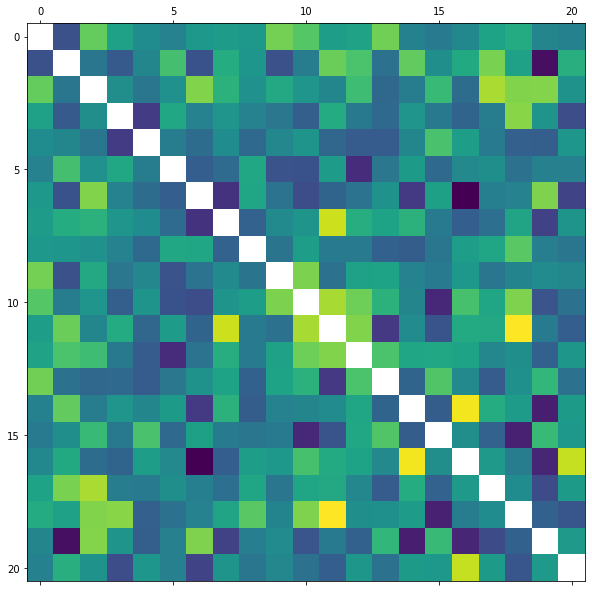

In [21]:
plt.matshow(roi_subj_avg)

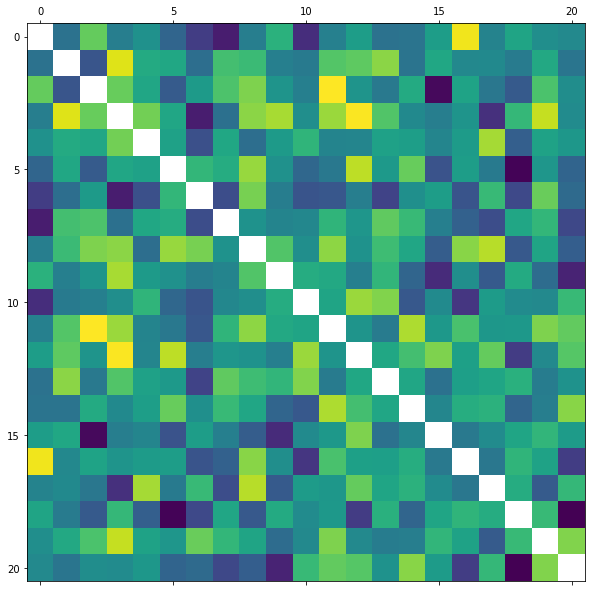

In [22]:
plt.matshow(roi_overall_avg)